# DEFCoN Tutorial

This tutorial is a quick introduction to using the Density Estimation Fully Convolutional Network (DEFCoN) for fluorescence spot counting in localization microscopy. This tutorial covers:

- [Importing images and ground truth datasets](#Importing Training Data)
- [Training DEFCoN](#Training)
- [Prediction](#Prediction)
- Exporting the network for Java applications

### Getting Help

If you have any questions, please ask in the DEFCoN Gitter chat room: https://gitter.im/leb_epfl/DEFCoN

### Additional Information

DEFCoN is part of a family of software packages for automating super-resolution microscopes from the [Laboratory of Experimental Biophysics](https://leb.epfl.ch/) at the École Polytechnique Fédérale de Lausanne (EPFL), Switzerland. The other packages include:

- [Automated Laser Illumination Control Algorithms (ALICA)](https://github.com/LEB-EPFL/ALICA)
- [SMLM Simulation Acquisition Software (SASS)](https://github.com/LEB-EPFL/SASS)

### Attribution

If you use DEFCoN in your own work, then please use the following citation.

> Ottino, B., Douglass, Kyle M., and Manley, S., "DEFCoN", https://github.com/kmdouglass/DEFCoN (2018)

A full citation will follow shortly.

# Preliminary Steps

Before running this tutorial, you should download the example datasets. These may be found at:

> Ottino, Baptiste, Douglass, Kyle M., & Manley, Suliana. (2018). Example datasets for DEFCoN (Version 2) [Data set]. Zenodo. http://doi.org/10.5281/zenodo.1207965

You may either do this manually, or run the code below to download the dataset directly to the same directory as this notebook.

In [1]:
import urllib.request as request
import zipfile
import os

url_root = 'https://zenodo.org/record/1207965/files/'
filename = 'DEFCoN_example_data.zip'
url = url_root + filename

# Download the zip file from Zenodo.
with request.urlopen(url) as host_file:
    with open(filename, 'wb') as client_file:
        client_file.write(host_file.read())
assert os.path.isfile(filename), 'Error: file {} does not exist.'.format(filename)

# Extract the contents of the file to the same directory as this notebook.
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('./')
    
# Delete the zip file
os.remove(filename)

example_dir = filename.split('.')[0]

# Importing Training Data

### Creating a TrainingSet

A `TrainingSet` is a set of SMLM images and additional ground truth information. For our purposes, the training images in this example were simulated using [SASS](https://github.com/LEB-EPFL/SASS). However, you can use any source of images so long as you have an accompanying ground truth file. This file is a comma separated value (CSV) file that contains information about the fluorophores that are emitting in each image. 

- Input images must be either in TIFF (.tif, .tiff) or HDF5 (.h5, .hdf5, .he5) formats.
- Image files may contain one or more images.
- Ground truth data must contain columns with the labels `frame`, `x`, `y`, and `brightness`.
    - The units of `x` and `y` are in pixels and support sub-pixel precisions.
    - The units of `brightness` are photons.
- Ground truth data may contain other columns, but these will be ignored.

Let's go ahead and create an instance of a TrainingSet.

In [2]:
from pathlib import Path
from leb.defcon.datasets import TrainingSet

h5_path = Path(example_dir) / Path('training/my_training_set.h5')

# Create a .h5 file, replace if exists
my_training_set = TrainingSet(h5_path, 'w')

/home/douglass/miniconda3/envs/defcon/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


At this point, the TrainingSet is empty.

In [3]:
my_training_set.summary()


DEFCoN_example_data/training/my_training_set.h5
/
    input/
    target/



The method `add_dataset` is used to add the input images to the TrainingSet and to build their density maps and segmentation masks from the ground truth.

In [4]:
from IPython.display import clear_output

dataset_name = 'first_dataset'
input_file = str(Path(example_dir) / Path('data_1/generated_stack.tif'))
frame_logger = str(Path(example_dir) / Path('data_1/frame_logger.csv'))

my_training_set.add_dataset(name=dataset_name,
                            input_file=input_file,
                            frame_logger=frame_logger)
clear_output()

The TrainingSet now looks like this:

In [5]:
my_training_set.summary()


DEFCoN_example_data/training/my_training_set.h5
/
    input/
        first_dataset: shape = (1500, 64, 64, 1), dtype = float64
    seg_map/
        first_dataset: shape = (1500, 64, 64, 1), dtype = int64
    target/
        first_dataset: shape = (1500, 64, 64, 1), dtype = float64



Adding a second dataset, the TrainingSet becomes:

In [6]:
dataset_name = 'second_dataset'
input_file = str(Path(example_dir) / Path('data_2/generated_stack.tif'))
frame_logger = str(Path(example_dir) / Path('data_2/frame_logger.csv'))

my_training_set.add_dataset(name=dataset_name,
                            input_file=input_file,
                            frame_logger=frame_logger)

clear_output()
my_training_set.summary()


DEFCoN_example_data/training/my_training_set.h5
/
    input/
        first_dataset: shape = (1500, 64, 64, 1), dtype = float64
        second_dataset: shape = (1500, 64, 64, 1), dtype = float64
    seg_map/
        first_dataset: shape = (1500, 64, 64, 1), dtype = int64
        second_dataset: shape = (1500, 64, 64, 1), dtype = int64
    target/
        first_dataset: shape = (1500, 64, 64, 1), dtype = float64
        second_dataset: shape = (1500, 64, 64, 1), dtype = float64



Because TrainingSets have an underlying HDF5 representation, you should always close the TrainingSet when you're done using it. (Even better is to use them within a Python `with`...`as` context manager, which will automatically close the TrainingSet for you. See https://www.python.org/dev/peps/pep-0343/ for more information.)

In [7]:
my_training_set.close()

### Creating a compact TrainingSet
To train faster, a TrainingSet containing multiple datasets can be compacted in a single large dataset, provided that _all input images have the same dimensions_.The images can be augmented (by random brightness changes) and shuffled in the process

In [8]:
from leb.defcon.datasets import compact_set

# This time, we open my_training_set in read_only mode
my_training_set = TrainingSet(h5_path, 'r')

# Output a compact training set named 'my_compact_set.h5'
h5_path_compact = str(Path(example_dir) / Path('training/my_compact_set.h5'))
compact_set(my_training_set,
            output_file=h5_path_compact,
            shuffle=True,
            augment=True)

# Close my_training_set
my_training_set.close()

assert os.path.isfile(h5_path_compact), 'Error: file {} does not exist.'.format(h5_path_compact)

Compacting input data...
    first_dataset...
    second_dataset...
Augmenting data...
Compacting seg_map data...
    first_dataset...
    second_dataset...
Compacting target data...
    first_dataset...
    second_dataset...


The result of compacting the datasets is that the images, segmentation map, and target density maps are now all stacked one-atop-the-other. This makes training faster because it minimizes the number of times that a HDF5 file needs to be opened and closed.

In [9]:
with TrainingSet(h5_path_compact) as my_compact_set:
    my_compact_set.summary()


DEFCoN_example_data/training/my_compact_set.h5
/
    input/
        input: shape = (3000, 64, 64, 1), dtype = float64
    seg_map/
        seg_map: shape = (3000, 64, 64, 1), dtype = int64
    target/
        target: shape = (3000, 64, 64, 1), dtype = float64



### Investigating the constructed maps

It may be useful to verify that the segmentation maps and target density maps have been constructed properly. To do this, we can use the underlying h5py [File](http://docs.h5py.org/en/latest/high/file.html) representation to access the datasets from within the file.

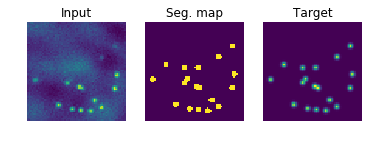

In [10]:
import h5py
%matplotlib inline
import matplotlib.pyplot as plt

frame_num = 2500

with h5py.File(h5_path_compact, 'r') as f:
    input_ex = f['input/input'][frame_num, :, :, :]
    seg_map  = f['seg_map/seg_map'][frame_num, :, :, :]
    target   = f['target/target'][frame_num, :, :, :]
    
fig, ax = plt.subplots(ncols=3)
ax[0].imshow(input_ex.squeeze()) # Squeeze just drops the extra singleton dimension on the arrays
ax[1].imshow(seg_map.squeeze())
ax[2].imshow(target.squeeze())

ax[0].set_title('Input')
ax[1].set_title('Seg. map')
ax[2].set_title('Target')

for a in ax:
    a.set_axis_off()
    
plt.show()

## Training

The training routine for DEFCoN consists of two steps:

1. train just the segmentation network;
2. freeze the segmentation network weights and train the full network (segmentation plus density networks).

These steps are implemented in the `train` method from the `leb.defcon.training` module. To perform the training, it is necessary to define the training parameters in a **config.ini** file. Within this file, we specify the locations of the training data, output directories, and several other parameters.

Here is what our example config.ini file looks like:

The first section just deals with the paths of the TrainingSet and the output model and weights. Note that the paths to the directories and training data file are **relative to the config.ini file**. The other sections let the user tune the parameters of the training.

The most efficient method for training is to train on a compact set of augmented and shuffled images.

To train a model, simply run the cell below.

**NOTE: It is highly recommended that you have Keras and Tensorflow configured for GPU use because training can be quite slow on a CPU.**

In [11]:
from leb.defcon import training

config_file = str(Path(example_dir) / Path('training/config.ini'))
training.train(config_file)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, None, 1)     0         
_________________________________________________________________
hist_norm (Lambda)           (None, None, None, 1)     0         
_________________________________________________________________
conv_seg_1 (Conv2D)          (None, None, None, 16)    160       
_________________________________________________________________
conv_stride_1 (Conv2D)       (None, None, None, 16)    2320      
_________________________________________________________________
conv_seg_2 (Conv2D)          (None, None, None, 32)    4640      
_________________________________________________________________
conv_stride_2 (Conv2D)       (None, None, None, 32)    9248      
_________________________________________________________________
conv_seg_3 (Conv2D)          (None, None, None, 64)    18496     
__________

The training script can also be run from the command line:

```sh
python training.py path_to_config_file
```

## Prediction

Predictions of density maps from images may be made on `TrainingSet` data or on images. `leb.defcon.networks.FCN` is a class inheriting methods from the Keras Model class and with additional methods for prediction and serving the data for Java applications.

In [12]:
from leb.defcon.networks import FCN
from leb.defcon.datasets import TrainingSet
import numpy as np

# Import the trained model from the saved h5 file
filename = str(Path(example_dir) / Path('training/trained_models/my_trained_model.h5'))
model = FCN.from_file(filename)

# Predict from array read from a HDF file
with TrainingSet(h5_path, 'r') as my_training_set:
    array = np.array(my_training_set['input/first_dataset'])

y_pred_array = model.predict(array)

# Predict from image stack
tif_file = str(Path(example_dir) / Path('data_1/generated_stack.tif'))
y_pred_tiff = model.predict_tiff(tif_file)

The prediction is a stack of density maps as a NumPy array with 4 dimensions: (N_frames, x, y, 1). The last dimension is the number of channels (1 because it is grayscale).

Let's visualize how well the network made the density map predictions.

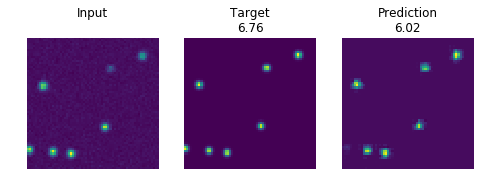

In [13]:
frame_num = 500

pred = y_pred_array[frame_num, :, :, :].squeeze()

with h5py.File(h5_path, 'r') as f:
    input_ex = f['input/first_dataset'][frame_num, :, :, :]
    target   = f['target/first_dataset'][frame_num, :, :, :]
    
fig, ax = plt.subplots(ncols=3, figsize=(8,3))
ax[0].imshow(input_ex.squeeze())
ax[1].imshow(target.squeeze())
ax[2].imshow(pred)

ax[0].set_title('Input\n')
ax[1].set_title('Target\n{:.2f}'.format(np.sum(target)))
ax[2].set_title('Prediction\n{:.2f}'.format(np.sum(pred)))

for a in ax:
    a.set_axis_off()
    
#plt.savefig('defcon_demo.png')
plt.show()

We can also see how well it does on actually counting the number of spots by directly summing over the prediction map.

In [14]:
print('Predicted spot count:\t{:.2f}'.format(np.sum(pred)))
print('Target spot count:\t{:.2f}'.format(np.sum(target)))

Predicted spot count:	6.02
Target spot count:	6.76


For better generalization and accuracy, you will want to train DEFCoN on a more diverse range and greater number of images than we did in this short example.

## Serving for Java

A trained DEFCoN model can be exported for use in other applications and languages, such as Java.

**This section should be run in a fresh environment. Restart the notebook kernel and proceed from this cell.**

In [ ]:
from leb.defcon.networks import FCN
from pathlib import Path

# Import the trained model from the saved h5 file
example_dir = 'DEFCoN_example_data'
file_in = str(Path(example_dir / Path('training/trained_models/my_trained_model.h5')))
model = FCN.from_file(file_in)

# Save it for serving
file_out = str(Path(example_dir) / Path('serving/tf_density_count'))
model.save_tf_model(file_out)

The resulting folder can be directly placed in the DEFCoN plugin directory in FIJI


Fiji.app/plugins/DEFCoN/tf_density_count

### Maximum local count

Trained DEFCoN model can be converted to allow for maximum count prediction by adding layers.

**This section should be run in a fresh environment. Restart the notebook kernel and proceed from this cell.**

In [ ]:
from leb.defcon.networks import FCN
from pathlib import Path

# Import the trained model from the saved h5 file
example_dir = 'DEFCoN_example_data'

# Import the trained model from the saved h5 file
filename = Path(example_dir) / Path('training/trained_models/my_trained_model.h5')
model = FCN.from_file(filename)
model.summary()

In [ ]:
# Adding prediction layer for max local count with 7x7 windows
model.density_to_max_count(pool=(7,7))
model.summary()

The resulting model can then be served for Java:

In [ ]:
model.save_tf_model('serving/tf_max_count')